## Generalized Linear Model (GLM)

A **Generalized Linear Model (GLM)** is an extension of linear regression that allows for response variables with different distributions (e.g., normal, binomial, Poisson). It consists of:

1. **Random component**: Specifies the distribution of the response variable.
2. **Systematic component**: A linear combination of predictors.
3. **Link function**: Connects the mean of the response variable to the linear predictor.

GLMs are flexible for modeling various types of data, such as binary outcomes or count data, while keeping a linear structure.

## Use Case 1: Crop Failure Prediction
Data:
    Features: Rainfall (mm), Temperature (°C), Soil Quality (scale 1-10), Irrigation method (0: None, 1: Drip, 2: Flood).
    Target: Crop Failure (0: No, 1: Yes)

Total records used for analysis: 100000


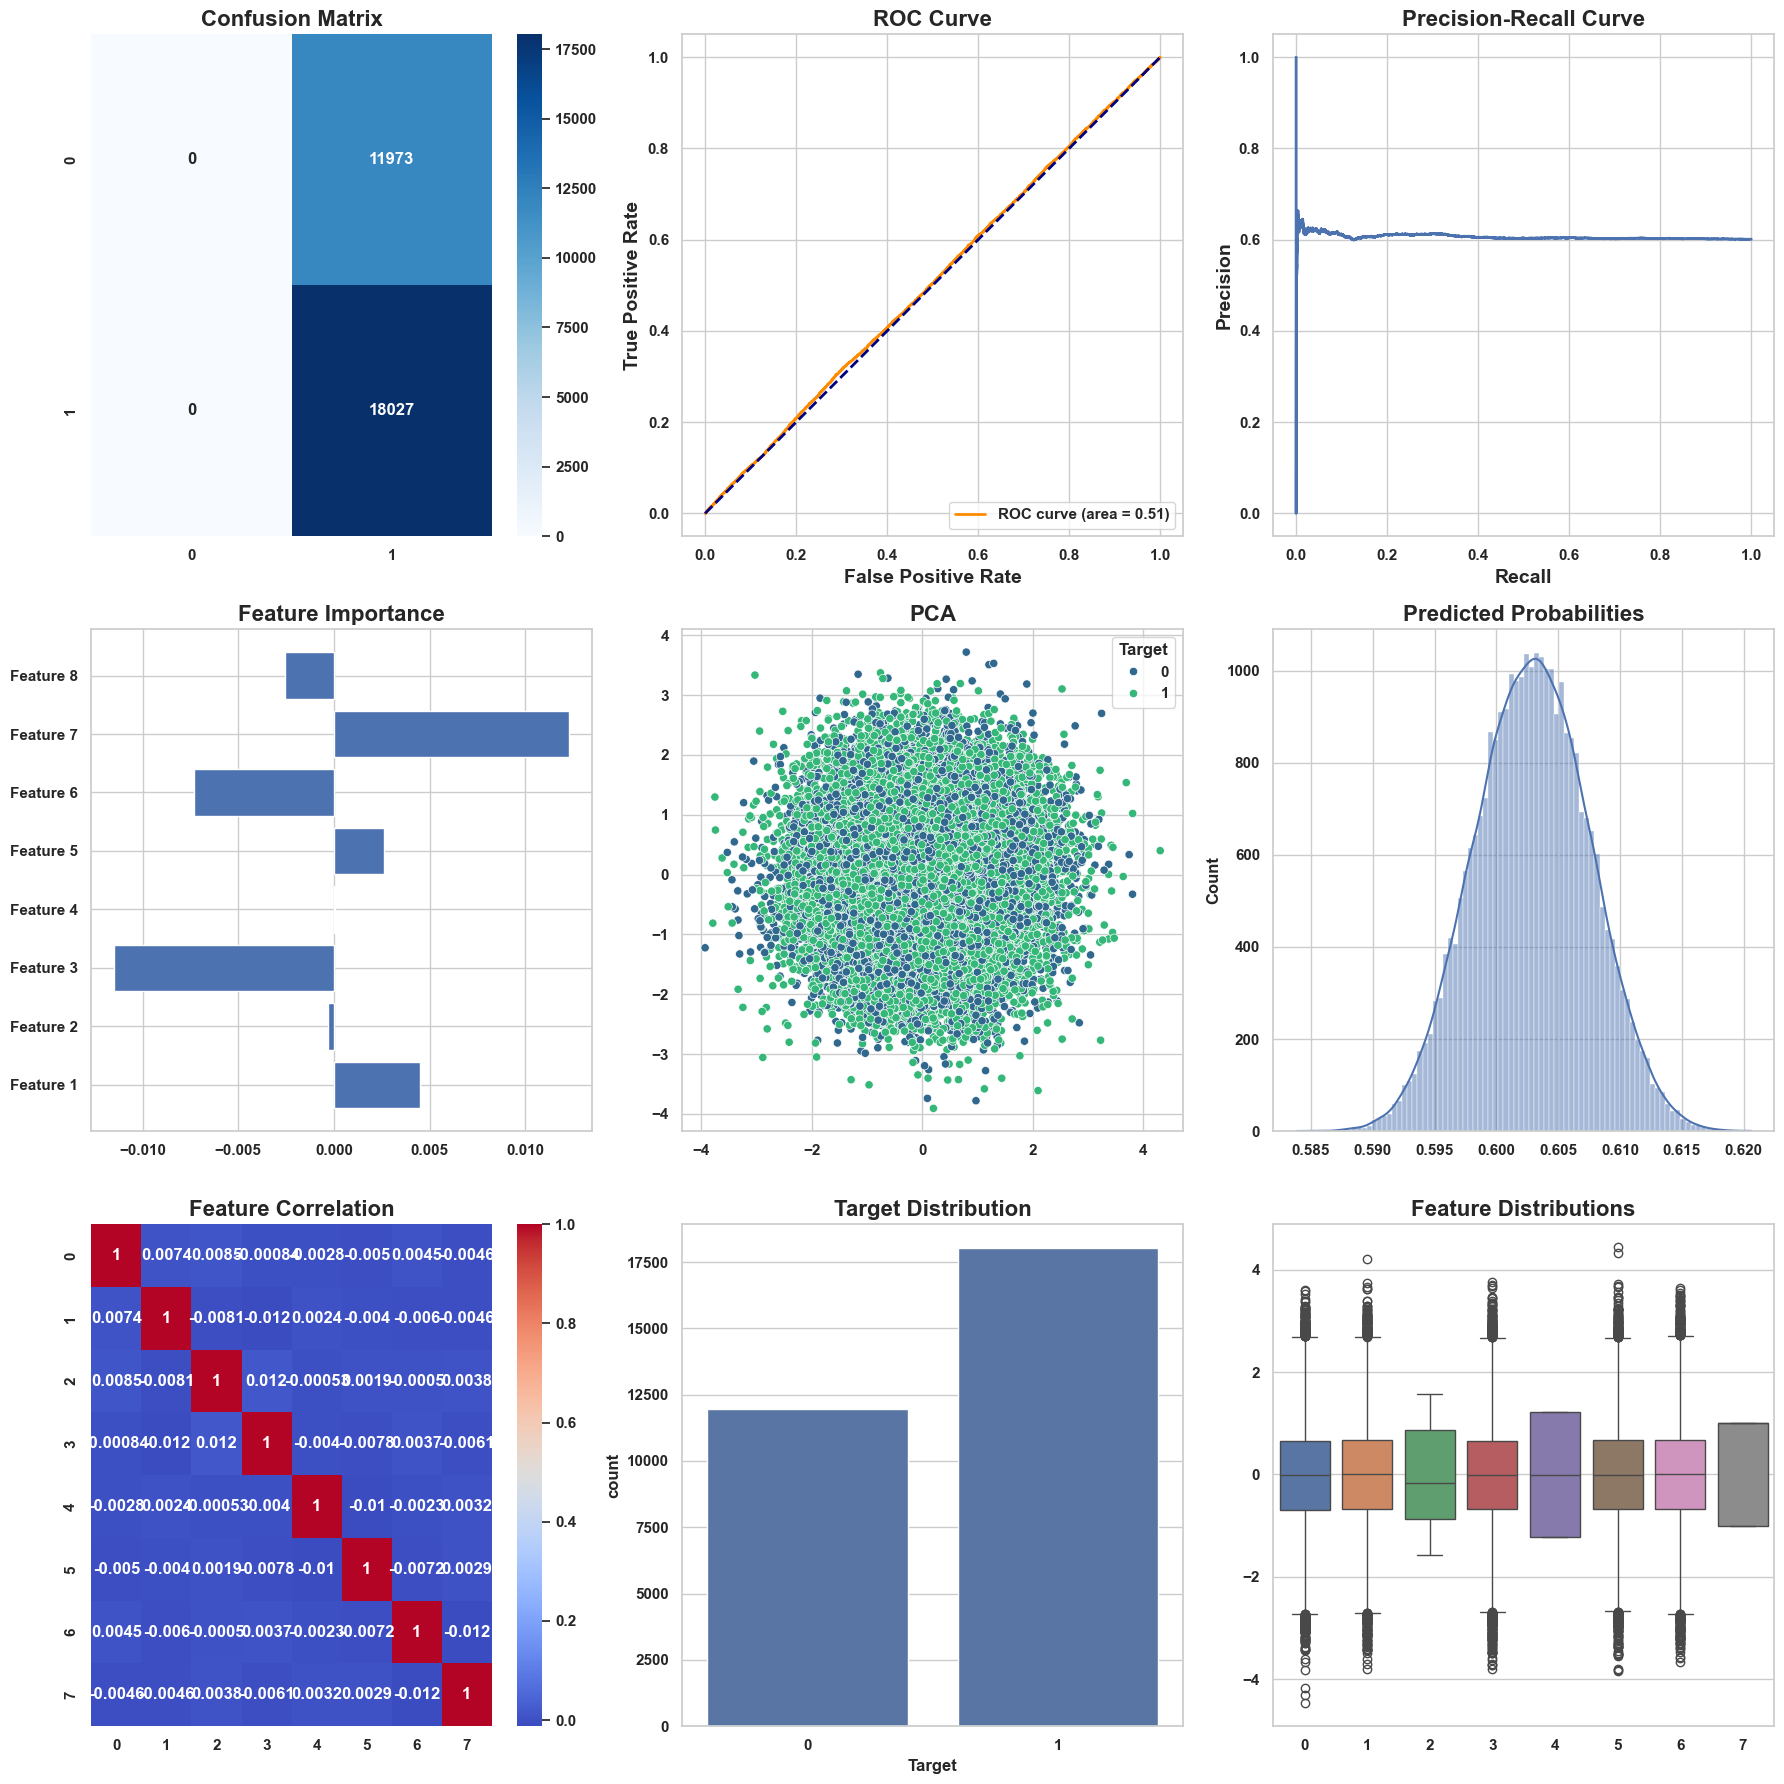


--- Model Evaluation Summary ---
Accuracy of the model: 0.60

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11973
           1       0.60      1.00      0.75     18027

    accuracy                           0.60     30000
   macro avg       0.30      0.50      0.38     30000
weighted avg       0.36      0.60      0.45     30000


Confusion Matrix Interpretation:
True Positives (TP): 0 (Correctly predicted crop success)
False Negatives (FN): 11973 (Incorrectly predicted failure when crop was successful)
False Positives (FP): 0 (Incorrectly predicted success when crop failed)
True Negatives (TN): 18027 (Correctly predicted crop failure)

Area under the ROC Curve (AUC): 0.51
The model has a moderate or poor ability to distinguish between the classes.

Precision-Recall Curve Interpretation:
The model performs well in predicting crop success (positive cases).

Specific Crop Failure Interpretation:
The model mi

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Set up for visuals
sns.set(style="whitegrid")
plt.rcParams.update({'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titlesize': 14, 'axes.labelsize': 12})

# Function to generate synthetic data for Crop Failure Prediction
def generate_data(n_samples=100000, random_state=42):
    """
    Generate synthetic data for crop failure prediction.
    """
    np.random.seed(random_state)

    # Random data generation for each feature
    temperature = np.random.normal(30, 5, n_samples)  # Average temperature (°C)
    rainfall = np.random.normal(100, 30, n_samples)  # Total rainfall (mm)
    soil_quality = np.random.randint(1, 11, n_samples)  # Soil quality rating (1-10)
    humidity = np.random.normal(70, 10, n_samples)  # Humidity (%)
    crop_type = np.random.choice(['Rice', 'Wheat', 'Maize'], n_samples)  # Crop type
    previous_yield = np.random.normal(1500, 500, n_samples)  # Previous yield (kg/hectare)
    pesticide_usage = np.random.normal(5, 2, n_samples)  # Pesticide usage (kg/hectare)
    irrigation_avail = np.random.choice([0, 1], n_samples)  # Irrigation availability (0=No, 1=Yes)
    
    # Target variable: 0 = Failure, 1 = Success
    target = np.random.choice([0, 1], n_samples, p=[0.4, 0.6])  # Simulate crop failure (60% success rate)

    # Create DataFrame
    data = pd.DataFrame({
        'Temperature': temperature,
        'Rainfall': rainfall,
        'SoilQuality': soil_quality,
        'Humidity': humidity,
        'CropType': crop_type,
        'PreviousYield': previous_yield,
        'PesticideUsage': pesticide_usage,
        'IrrigationAvailable': irrigation_avail,
        'Target': target
    })

    # Convert categorical feature 'CropType' to numeric using LabelEncoder
    label_encoder = LabelEncoder()
    data['CropType'] = label_encoder.fit_transform(data['CropType'])

    return data

# Function to train and evaluate the model
def train_and_evaluate(X_train, X_test, y_train, y_test):
    """
    Train a Logistic Regression model and evaluate it on the test set.
    """
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    return model, y_pred, X_test_scaled, y_test

# Function to plot various evaluation metrics
def plot_evaluation_metrics(model, X_test_scaled, y_test):
    """
    Plot confusion matrix, ROC curve, precision-recall curve, and other metrics.
    """
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, model.predict(X_test_scaled))
    
    # Set up subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.ravel()

    # 1. Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title('Confusion Matrix', fontsize=16, weight='bold')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_title('ROC Curve', fontsize=16, weight='bold')
    axes[1].set_xlabel('False Positive Rate', fontsize=14, weight='bold')
    axes[1].set_ylabel('True Positive Rate', fontsize=14, weight='bold')
    axes[1].legend(loc="lower right", prop={'weight': 'bold'})

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    axes[2].plot(recall, precision, color='b', lw=2)
    axes[2].set_title('Precision-Recall Curve', fontsize=16, weight='bold')
    axes[2].set_xlabel('Recall', fontsize=14, weight='bold')
    axes[2].set_ylabel('Precision', fontsize=14, weight='bold')

    # 4. Feature Importance (Logistic Regression Coefficients)
    coefficients = model.coef_.flatten()
    axes[3].barh(range(len(coefficients)), coefficients, align='center')
    axes[3].set_yticks(range(len(coefficients)))
    axes[3].set_yticklabels([f"Feature {i+1}" for i in range(len(coefficients))])
    axes[3].set_title('Feature Importance', fontsize=16, weight='bold')

    # 5. PCA for Dimensionality Reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test_scaled)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='viridis', ax=axes[4])
    axes[4].set_title('PCA', fontsize=16, weight='bold')

    # 6. Distribution of Predicted Probabilities
    sns.histplot(model.predict_proba(X_test_scaled)[:, 1], kde=True, ax=axes[5])
    axes[5].set_title('Predicted Probabilities', fontsize=16, weight='bold')

    # 7. Correlation Heatmap of Features
    corr_matrix = pd.DataFrame(X_test_scaled).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[6])
    axes[6].set_title('Feature Correlation', fontsize=16, weight='bold')

    # 8. Distribution of Target Variable
    sns.countplot(x=y_test, ax=axes[7])
    axes[7].set_title('Target Distribution', fontsize=16, weight='bold')

    # 9. Boxplot of Feature Distributions
    sns.boxplot(data=pd.DataFrame(X_test_scaled), ax=axes[8])
    axes[8].set_title('Feature Distributions', fontsize=16, weight='bold')

    plt.tight_layout()
    plt.show()

# Function to print evaluation results with specific interpretation for crop failure
def print_evaluation_results(y_test, y_pred, model, conf_matrix):
    """
    Print classification report, confusion matrix interpretation, and AUC score with specific crop failure analysis.
    """
    print("\n--- Model Evaluation Summary ---")
    
    # Model Evaluation Metrics
    accuracy = (y_pred == y_test).mean()
    print(f"Accuracy of the model: {accuracy:.2f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Interpretation
    tp, fn, fp, tn = conf_matrix.ravel()
    print(f"\nConfusion Matrix Interpretation:")
    print(f"True Positives (TP): {tp} (Correctly predicted crop success)")
    print(f"False Negatives (FN): {fn} (Incorrectly predicted failure when crop was successful)")
    print(f"False Positives (FP): {fp} (Incorrectly predicted success when crop failed)")
    print(f"True Negatives (TN): {tn} (Correctly predicted crop failure)")

    # ROC Curve Interpretation
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"\nArea under the ROC Curve (AUC): {roc_auc:.2f}")
    if roc_auc > 0.8:
        print("The model has a good ability to distinguish between crop failure and success.")
    else:
        print("The model has a moderate or poor ability to distinguish between the classes.")

    # Precision-Recall Curve Interpretation
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    print("\nPrecision-Recall Curve Interpretation:")
    if precision[-1] > 0.7:
        print("The model performs well in predicting crop success (positive cases).")
    else:
        print("The model might be struggling to identify crop success accurately.")

    # Crop Failure Specific Interpretation:
    print("\nSpecific Crop Failure Interpretation:")
    if fn > 0:
        print("The model might need improvement to reduce false negatives, ensuring more crop success cases are identified correctly.")
    if fp > 0:
        print("The model may need refinement to avoid incorrectly predicting crop success in failure cases.")

if __name__ == "__main__":
    # Generate synthetic data for crop failure prediction
    data = generate_data(n_samples=100000)

    # Split the data into features and target variable
    X = data.drop(columns='Target')
    y = data['Target']
    print(f"Total records used for analysis: {X.shape[0]}")

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train and evaluate the model
    model, y_pred, X_test_scaled, y_test = train_and_evaluate(X_train, X_test, y_train, y_test)

    # Plot evaluation metrics
    plot_evaluation_metrics(model, X_test_scaled, y_test)

    # Print evaluation results
    conf_matrix = confusion_matrix(y_test, y_pred)
    print_evaluation_results(y_test, y_pred, model, conf_matrix)


## Use Case 2: Farm Profitability Prediction
Data:
    
    Features: Crop Type (0: Wheat, 1: Rice, 2: Corn), Land Area (in hectares), Irrigation method (0: None, 1: Drip, 2: Flood), Rainfall (mm).
    Target: Profitability (0: Not Profitable, 1: Profitable)

Crop-wise record count for analysis:
  - Wheat (0): 30055
  - Rice (1): 40056
  - Corn (2): 29889
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     11712
           1       0.61      1.00      0.76     18288

    accuracy                           0.61     30000
   macro avg       0.30      0.50      0.38     30000
weighted avg       0.37      0.61      0.46     30000



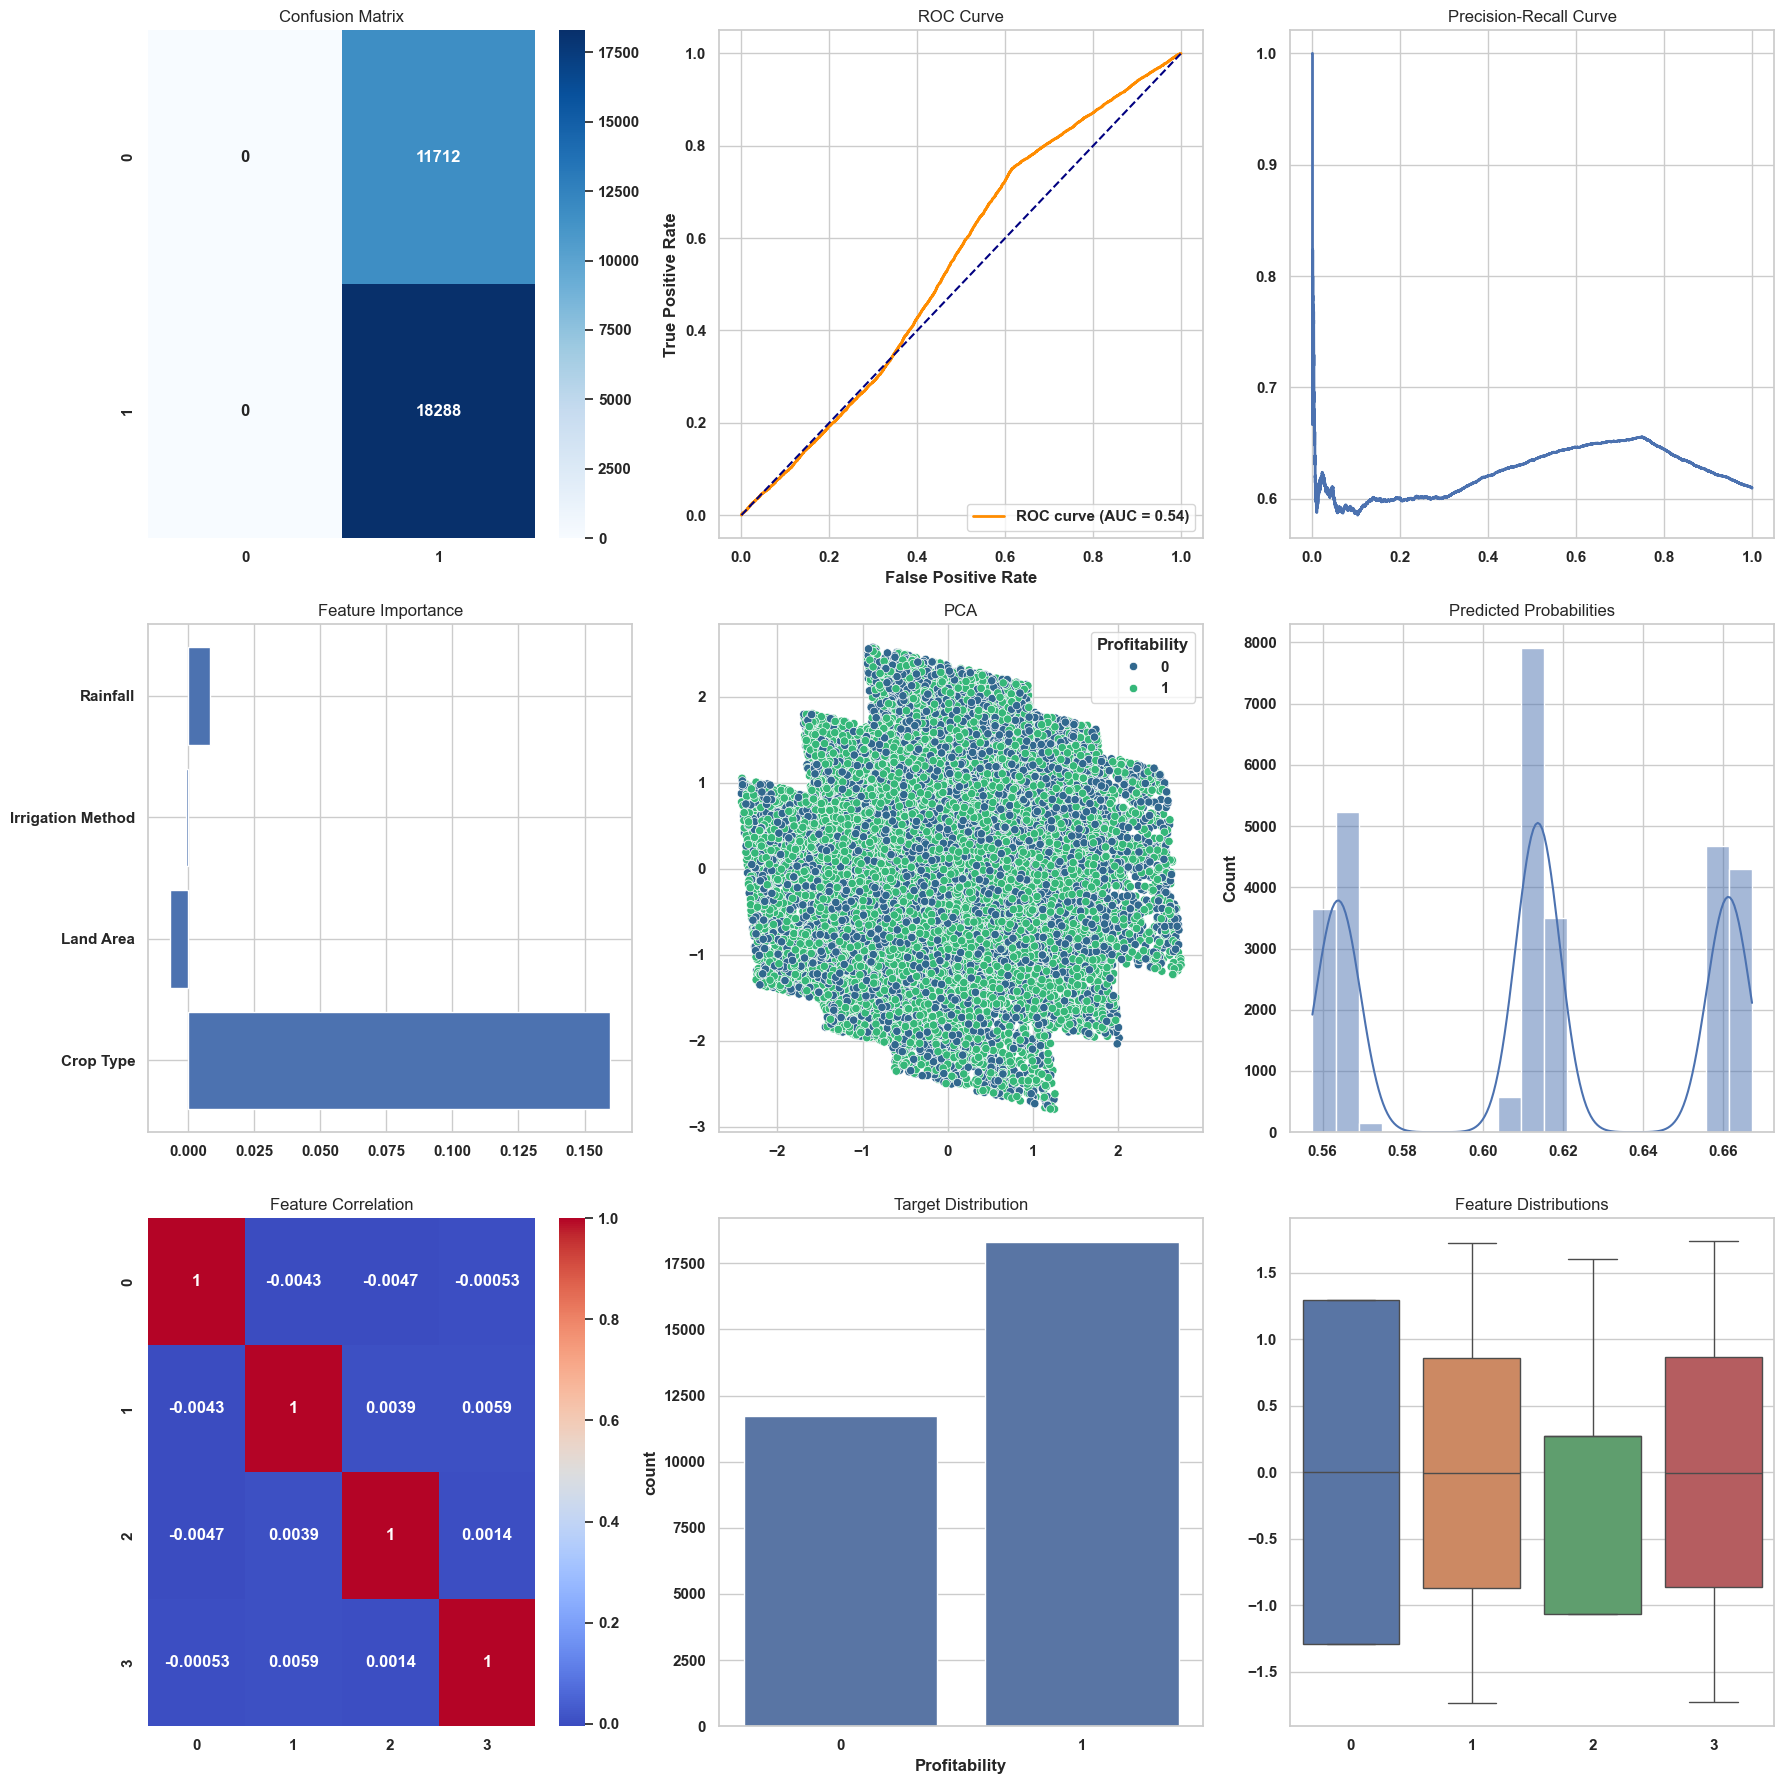


Dynamic Interpretation:

- Model Performance:
  - Accuracy: 0.61
  - Precision: 0.61
  - Recall: 1.00
  - F1-Score: 0.76

- Crop Profitability:
  - Crop 0: 0.50
  - Crop 1: 0.70
  - Crop 2: 0.60

- Feature Importance:
Crop Type            0.159668
Rainfall             0.008131
Irrigation Method   -0.000872
Land Area           -0.006810
dtype: float64

- Interpretation:
  - Crop Type: Importance = 0.16
  - Land Area: Importance = -0.01
  - Irrigation Method: Importance = -0.00
  - Rainfall: Importance = 0.01
  - Higher profitability crop: Crop 1 generally has the highest average profitability of 0.70.


In [16]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Visuals setup
sns.set(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples for each crop
n_samples = 100000

# Define feature names and their corresponding probabilities or ranges
features = {
    'Crop Type': {'values': [0, 1, 2], 'probabilities': [0.3, 0.4, 0.3]},  # 30% Wheat, 40% Rice, 30% Corn
    'Land Area': {'values': (10, 500), 'type': 'uniform'},  # Land area in hectares
    'Irrigation Method': {'values': [0, 1, 2], 'probabilities': [0.4, 0.4, 0.2]},  # 40% No Irrigation, 40% Drip, 20% Flood
    'Rainfall': {'values': (300, 1200), 'type': 'uniform'}  # Rainfall in mm
}

# Generate synthetic dataset
data = {}
for feature, params in features.items():
    if params.get('type') == 'uniform':
        data[feature] = np.random.uniform(params['values'][0], params['values'][1], size=n_samples)
    else:
        data[feature] = np.random.choice(params['values'], size=n_samples, p=params['probabilities'])

# Crop-specific probabilities of profitability
profitability_probabilities = np.where(data['Crop Type'] == 0, 0.5,  # Wheat
                                        np.where(data['Crop Type'] == 1, 0.7,  # Rice
                                                 0.6))  # Corn

# Generate target variable based on profitability probabilities
data['Profitability'] = np.random.binomial(1, profitability_probabilities)

# Convert to DataFrame
df = pd.DataFrame(data)

# Print crop-wise record count before analysis
crop_counts = df['Crop Type'].value_counts().sort_index()
print("Crop-wise record count for analysis:")
print(f"  - Wheat (0): {crop_counts[0]}")
print(f"  - Rice (1): {crop_counts[1]}")
print(f"  - Corn (2): {crop_counts[2]}")

# Split data into features and target variable
X = df.drop(columns=['Profitability'])
y = df['Profitability']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression Model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_scaled, y_train)

# Predictions & Model Performance
y_pred = model.predict(X_test_scaled)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizations setup
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.ravel()

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc(fpr, tpr):.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
axes[2].plot(recall, precision, color='b', lw=2)
axes[2].set_title('Precision-Recall Curve')

# Feature Importance (Logistic Regression Coefficients)
coefficients = model.coef_.flatten()
axes[3].barh(range(len(coefficients)), coefficients, align='center')
axes[3].set_yticks(range(len(coefficients)))
axes[3].set_yticklabels(X.columns)
axes[3].set_title('Feature Importance')

# PCA Visualization
X_pca = PCA(n_components=2).fit_transform(X_test_scaled)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='viridis', ax=axes[4])
axes[4].set_title('PCA')

# Predicted Probabilities Distribution
sns.histplot(model.predict_proba(X_test_scaled)[:, 1], kde=True, ax=axes[5])
axes[5].set_title('Predicted Probabilities')

# Feature Correlation Heatmap
sns.heatmap(pd.DataFrame(X_train_scaled).corr(), annot=True, cmap='coolwarm', ax=axes[6])
axes[6].set_title('Feature Correlation')

# Target Distribution
sns.countplot(x=y_test, ax=axes[7])
axes[7].set_title('Target Distribution')

# Feature Distributions Boxplot
sns.boxplot(data=pd.DataFrame(X_train_scaled), ax=axes[8])
axes[8].set_title('Feature Distributions')

plt.tight_layout()
plt.show()

# Dynamic Interpretation Section
print("\nDynamic Interpretation:")

# Confusion Matrix Insights
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Key Insights
print(f"\n- Model Performance:")
print(f"  - Accuracy: {accuracy:.2f}")
print(f"  - Precision: {precision:.2f}")
print(f"  - Recall: {recall:.2f}")
print(f"  - F1-Score: {f1_score:.2f}")

# Crop-specific profitability insights:
crop_profitability = df.groupby('Crop Type')['Profitability'].mean()

print(f"\n- Crop Profitability:")
for crop, prob in crop_profitability.items():
    print(f"  - Crop {crop}: {prob:.2f}")

# Feature Importance insights
feature_importance = pd.Series(coefficients, index=X.columns)
print(f"\n- Feature Importance:")
print(feature_importance.sort_values(ascending=False))

# Interpretation
print(f"\n- Interpretation:")
for i, feature in enumerate(X.columns):
    importance = feature_importance[feature]
    print(f"  - {feature}: Importance = {importance:.2f}")

# Identify the most profitable crop 
most_profitable_crop = crop_profitability.idxmax()  # Get the crop with the highest profitability
most_profitable_prob = crop_profitability.max()  # Get the highest profitability value

# Most profitable crop
print(f"  - Higher profitability crop: Crop {most_profitable_crop} generally has the highest average profitability of {most_profitable_prob:.2f}.")
